In [111]:
# Subword level similarities

In [112]:
import os, sys
sys.path.append("../")
from crawled_data import CrawledData
from collections import Counter
from itertools import combinations
import pandas as pd
import math
import json
import string
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from scipy.stats import entropy

In [113]:
# Read data

In [114]:
data_obj = CrawledData()
data_obj.read_crawled_data("../data/crawled/folksongs/", remove_punctuation = True)
print(data_obj.data.keys())
data_obj.read_crawled_data("../data/crawled/poetry/", remove_punctuation = True)
print(data_obj.data.keys())
acc_data = dict()


Getting files for rajasthani
Getting files for gujarati
Getting files for himachali
Getting files for hindi-urdu
Getting files for magahi
Getting files for awadhi
Getting files for punjabi
Getting files for koraku
Getting files for baiga
Getting files for .DS_Store
Getting files for nimaadi
Getting files for khadi_boli
Getting files for bhojpuri
Getting files for garwali
Getting files for chattisgarhi
Getting files for brajbhasha
Getting files for bhil
Getting files for sanskrit
Getting files for angika
Getting files for hariyanvi
Getting files for kannauji
Getting files for bundeli
Getting files for bangla
Getting files for malwi
Getting files for marathi
Getting files for kumaoni
Getting files for bhadavari
dict_keys(['rajasthani', 'gujarati', 'himachali', 'hindi-urdu', 'magahi', 'awadhi', 'punjabi', 'koraku', 'baiga', 'nimaadi', 'khadi_boli', 'bhojpuri', 'garwali', 'chattisgarhi', 'brajbhasha', 'bhil', 'sanskrit', 'angika', 'hariyanvi', 'kannauji', 'bundeli', 'bangla', 'malwi', 'mar

In [115]:
langs = [
"sindhi",
"rajasthani",
"punjabi",
"hariyanvi",
#"gujarati",
"khadi_boli",
#"sanskrit",
"hindi-urdu",
"bhil",
"koraku",
"baiga",
"nimaadi",
"malwi",
"marathi",
"bhadavari",
"himachali",
"garwali",
"kumaoni",
"kannauji",
"brajbhasha",
"bundeli",
"awadhi",
"chattisgarhi",
"nepali",
#"pali",
"bhojpuri",
"bajjika",
"magahi",
"maithili",
"angika",
#"bangla"
        ]

north = ["sindhi", "punjabi", "hariyanvi", "bhadavari", "himachali", "garwali", "kumaoni", "kannauji", "nepali"]
north_central = ["sindhi", "rajasthani", "punjabi", "hariyanvi", "hindi-urdu", "khadi_boli", "kannauji", "brajbhasha", "bundeli", \
                "awadhi", "chattisgarhi", "bhojpuri", "bajjika", "magahi", "maithili", "angika"]
central = ["rajasthani", "hindi-urdu", "gujarati", "bhil", "koraku", "baiga", "nimaadi", "malwi", "marathi", "chattisgarhi"]

# langs = [lang for lang in langs if lang in north_central]

for idx, lang in enumerate(langs):
    print(idx, lang)

0 sindhi
1 rajasthani
2 punjabi
3 hariyanvi
4 khadi_boli
5 hindi-urdu
6 bhil
7 koraku
8 baiga
9 nimaadi
10 malwi
11 marathi
12 bhadavari
13 himachali
14 garwali
15 kumaoni
16 kannauji
17 brajbhasha
18 bundeli
19 awadhi
20 chattisgarhi
21 nepali
22 bhojpuri
23 bajjika
24 magahi
25 maithili
26 angika


In [121]:
# Cleaning accumulated data
dev_range = range(2305, 2404)
for lang in langs:
    acc_data[lang] = " ".join([data_obj.data[lang][file_id]["text"] for file_id in data_obj.data[lang]])
    acc_data[lang] = "".join([c if ord(c) in dev_range else " " for c in acc_data[lang]])
    acc_data[lang] = " ".join(acc_data[lang].split())


In [116]:
# remove_langs = ["gujarati", "pali", "sanskrit", "bangla"]
# langs = [lang for lang in data_obj.data.keys() if lang not in remove_langs]

In [117]:
len(langs)

27

In [118]:
#Get frequency dist of i-chargrams of a single language

In [125]:
def check_chars(cgram):
    
    dev_range = range(2305, 2404)
    for c in cgram:
        if ord(c) not in dev_range:
            return False
    return True


def get_i_chargram_freq(text, i):
    
    i_cg_set = Counter()

    for idx, c in enumerate(text):
        if idx + i <= len(text):
            cgram = text[idx:idx+i]
            if check_chars(cgram):
                i_cg_set[cgram] += 1
            
    return i_cg_set
    
    

In [126]:
#Get freq dist of i-chargrams of all languages
lang_cgrams = dict()
cgram_range = range(2,5)

for window in cgram_range:
    lang_cgrams[window] = dict()
    for lang in langs:
        lang_cgrams[window][lang] = get_i_chargram_freq(acc_data[lang], window)




In [10]:
# Printing out length of all chargram sets
for window in cgram_range:
    print(window)
    for lang in langs:
        print(lang)
        print(len(set(lang_cgrams[window][lang])))

2
sindhi
2889
rajasthani
3962
punjabi
2698
hariyanvi
3308
khadi_boli
1404
hindi-urdu
10596
bhil
2054
koraku
1176
baiga
1748
nimaadi
2105
malwi
1477
marathi
1544
bhadavari
550
himachali
455
garwali
3593
kumaoni
777
kannauji
494
brajbhasha
4458
bundeli
2175
awadhi
4619
chattisgarhi
2800
nepali
5412
bhojpuri
3961
bajjika
1690
magahi
3234
maithili
4421
angika
5526
3
sindhi
25551
rajasthani
47722
punjabi
27997
hariyanvi
40669
khadi_boli
5579
hindi-urdu
148052
bhil
14419
koraku
6016
baiga
10182
nimaadi
12440
malwi
8090
marathi
5782
bhadavari
1139
himachali
920
garwali
39214
kumaoni
1894
kannauji
932
brajbhasha
48086
bundeli
18712
awadhi
64744
chattisgarhi
28143
nepali
72466
bhojpuri
46397
bajjika
9551
magahi
35801
maithili
55583
angika
86950
4
sindhi
78999
rajasthani
204088
punjabi
90856
hariyanvi
183750
khadi_boli
8959
hindi-urdu
1007961
bhil
37325
koraku
13440
baiga
22774
nimaadi
25444
malwi
16844
marathi
9338
bhadavari
1361
himachali
1157
garwali
135831
kumaoni
2362
kannauji
1073
brajbhas

In [127]:
# Printing out length of all chargram sets
for window in cgram_range:
    print(window)
    for lang in langs:
        print(lang)
        print(len(set(lang_cgrams[window][lang])))

2
sindhi
1669
rajasthani
2173
punjabi
1704
hariyanvi
2098
khadi_boli
930
hindi-urdu
3435
bhil
1364
koraku
881
baiga
1124
nimaadi
1332
malwi
1077
marathi
940
bhadavari
370
himachali
313
garwali
2019
kumaoni
536
kannauji
354
brajbhasha
2127
bundeli
1541
awadhi
2356
chattisgarhi
1819
nepali
2600
bhojpuri
2196
bajjika
1211
magahi
1925
maithili
2473
angika
2704
3
sindhi
9062
rajasthani
18161
punjabi
10026
hariyanvi
15038
khadi_boli
2062
hindi-urdu
42809
bhil
5469
koraku
2766
baiga
3687
nimaadi
4524
malwi
3351
marathi
2621
bhadavari
469
himachali
383
garwali
14235
kumaoni
794
kannauji
407
brajbhasha
16583
bundeli
7126
awadhi
22239
chattisgarhi
10918
nepali
27143
bhojpuri
17819
bajjika
3754
magahi
12582
maithili
20827
angika
29155
4
sindhi
14264
rajasthani
37653
punjabi
15816
hariyanvi
28671
khadi_boli
1744
hindi-urdu
152414
bhil
6890
koraku
3041
baiga
3886
nimaadi
4740
malwi
3555
marathi
2757
bhadavari
310
himachali
288
garwali
25940
kumaoni
575
kannauji
262
brajbhasha
34502
bundeli
8997
awa

In [132]:
# First, we "clean" the dictionary, i.e. we remove words that occur only 1 time

for window in cgram_range:
    print("WINDOW ", window)
    print("\n\n")
    for lang in langs:
        print(lang)
        print("Number of unique grams: ", len(lang_cgrams[window][lang]))
        lexicon = set(lang_cgrams[window][lang].keys())
        total_grams = sum(lang_cgrams[window][lang].values())
        print("Number of total grams: ", total_grams)
        threshold = math.log(total_grams, 100) - 1
        for cgram in lexicon:
            if lang_cgrams[window][lang][cgram] < threshold:
                del lang_cgrams[window][lang][cgram]
        print("Threshold: ", threshold)
        print("Post cleaning: ", len(lang_cgrams[window][lang]))


    


WINDOW  2



sindhi
Number of unique grams:  1437
Number of total grams:  150858
Threshold:  1.5892841728794047
Post cleaning:  1437
rajasthani
Number of unique grams:  1952
Number of total grams:  516187
Threshold:  1.8564035313908693
Post cleaning:  1952
punjabi
Number of unique grams:  1496
Number of total grams:  187394
Threshold:  1.6363778407449114
Post cleaning:  1496
hariyanvi
Number of unique grams:  1857
Number of total grams:  618203
Threshold:  1.8955655541328795
Post cleaning:  1857
khadi_boli
Number of unique grams:  702
Number of total grams:  11747
Threshold:  1.0349634843762359
Post cleaning:  702
hindi-urdu
Number of unique grams:  2945
Number of total grams:  18639322
Threshold:  2.635215055483928
Post cleaning:  2945
bhil
Number of unique grams:  1177
Number of total grams:  73693
Threshold:  1.4337131183816663
Post cleaning:  1177
koraku
Number of unique grams:  845
Number of total grams:  47023
Threshold:  1.336155166519128
Post cleaning:  845
baiga
Number of uniq

In [129]:
# totals = {window: sum([lang_cgrams[window][lang].keys() for lang in langs]) for window in cgram_range}
totals = {window: len({cgram for lang in langs for cgram in lang_cgrams[window][lang]}) for window in cgram_range}

In [130]:
totals

{2: 3309, 3: 41026, 4: 138139}

In [146]:
def find_shared_cgrams(langs, lang_cgrams, window, kl = False):
    '''Calculate either cgram similarity or Kullback-Leibler divergence'''
    N = len(langs)    
    shared_lex_metrics = [[0]*N for _ in range(N)]

    for i, j in combinations(range(N), 2):
        l_1, l_2 = langs[i], langs[j]
        lex_l_1, lex_l_2 = set(lang_cgrams[window][l_1].keys()), set(lang_cgrams[window][l_2].keys())
        shared_lex = list(lex_l_1.intersection(lex_l_2))
        if kl:
            l_1_dist = [lang_cgrams[window][l_1][cgram] for cgram in shared_lex]
            l_2_dist = [lang_cgrams[window][l_2][cgram] for cgram in shared_lex]
            klp = (entropy(pk = l_1_dist, qk = l_2_dist) + entropy(pk = l_2_dist, qk = l_1_dist))/2
            shared_lex_metrics[i][j] = shared_lex_metrics[j][i] = klp 
            
        else:
            normalization = len(lex_l_1.union(lex_l_2))/2
#             normalization = min(len(lex_l_1), len(lex_l_2))
            shared_lex_metrics[i][j] = shared_lex_metrics[j][i] = len(shared_lex)/normalization
            

    shared_lex_metrics = np.asarray(shared_lex_metrics)

    for i in range(N):
        if kl:
            shared_lex_metrics[i][i] = 0
        else:
            shared_lex_metrics[i][i] = 1
#         shared_lex_dict[langs[i]][langs[i]] = 1
    
    return shared_lex_metrics

In [163]:
# Cgram similarity
N = len(langs)    
find_range = range(4,5)
shared_cgram_total = np.zeros((N,N))
normalization = sum([totals[window] for window in find_range])
for window in find_range:
    shared_cgram_total += totals[window]*find_shared_cgrams(langs, lang_cgrams, window, kl = False)/normalization


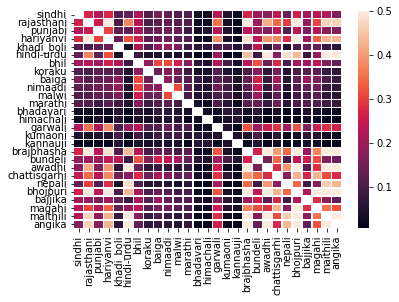

In [165]:
ax = sns.heatmap(shared_cgram_total, linewidth=0.3, mask = shared_cgram_total == 1, vmax = 0.5, xticklabels=langs, yticklabels=langs)#, annot=True, annot_kws={"size":6})
fig = ax.get_figure()
fig.savefig("stats_outputs/subword_similarity/igrams.4.norm_union.png")

In [39]:
# investigating subword similarity
len(set(lang_cgrams[3]["bhadavari"].keys()))



1139

In [150]:
# KL Divergence
N = len(langs)    
find_range = range(3,5)
klp_total = np.zeros((N,N))
for window in find_range:
    klp_total += find_shared_cgrams(langs, lang_cgrams, window, kl = True)

klp_total = klp_total/len(find_range)

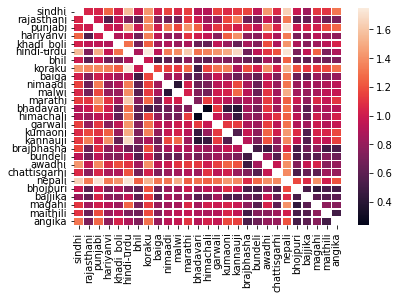

In [151]:
ax = sns.heatmap(klp_total, linewidth=0.3, mask = klp_total == 0, xticklabels=langs, yticklabels=langs)#, annot=True, annot_kws={"size":6})
fig = ax.get_figure()
fig.savefig("stats_outputs/subword_similarity/klp-igrams-3,4.png")

In [70]:
klp_total[0,1]

1.0155788635877205